In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

2025-11-25 15:50:51.339016: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 15:50:51.439579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 15:50:53.125460: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Load dataset

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

2025-11-25 15:51:02.833201: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
print(ds_info)
print("\nLabel names:", ds_info.features["label"].names)
print("\nImage shape:", ds_info.features["image"].shape)
print("\nTrain size:", ds_info.splits["train"].num_examples)
print("Test size:", ds_info.splits["test"].num_examples)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='/home/robby/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.co

Random sample image

2025-11-25 15:51:28.473627: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-11-25 15:51:28.607474: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


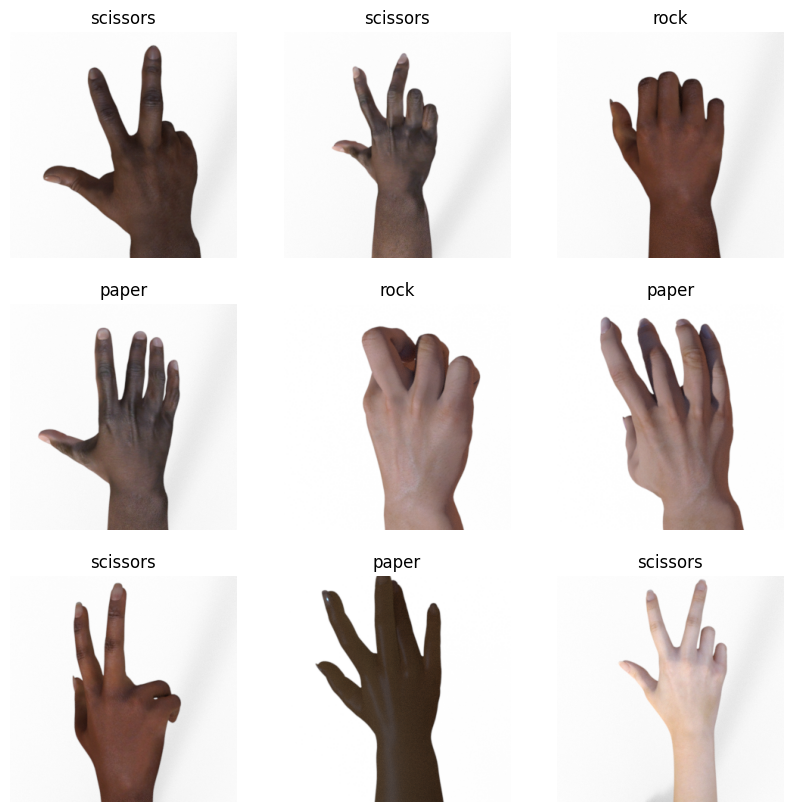

In [ ]:
# random 9 sampel
example_samples = ds_train.take(9)

plt.figure(figsize=(10,10))
i = 1
for image_, label_ in example_samples:
    plt.subplot(3,3,i)
    plt.imshow(image_)
    plt.title(["rock", "paper", "scissors"][label_])
    plt.axis("off")
    i += 1

plt.show()

Preprocessing

In [8]:
IMG_SIZE = 150

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

train_ds = ds_train.map(format_image).cache().shuffle(500).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds  = ds_test.map(format_image).cache().batch(32).prefetch(tf.data.AUTOTUNE)

Model

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

/home/robby/robby-dev/rps-image-classification/jupyter_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Training

In [12]:
history = model.fit(
    train_ds,
    epochs=15,
    validation_data=test_ds
)

Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8417 - loss: 0.3767 - val_accuracy: 0.8737 - val_loss: 0.4029
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 324ms/step - accuracy: 0.9952 - loss: 0.0182 - val_accuracy: 0.8414 - val_loss: 0.5269
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 329ms/step - accuracy: 0.9992 - loss: 0.0026 - val_accuracy: 0.8011 - val_loss: 0.9208
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 325ms/step - accuracy: 0.9952 - loss: 0.0189 - val_accuracy: 0.7581 - val_loss: 0.8206
Epoch 5/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 326ms/step - accuracy: 0.9976 - loss: 0.0061 - val_accuracy: 0.7849 - val_loss: 0.8523
Epoch 6/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 323ms/step - accuracy: 1.0000 - loss: 3.4588e-04 - val_accuracy: 0.7688 - val_loss: 1.1579
Epoch 7/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 327ms/step - accuracy: 1.0000 - loss: 2.1948e-04 - val_accuracy: 0.7715 - val_loss: 1.3572
Epoch 8/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 326ms/step - accuracy: 1.0000 - loss: 8.7603e-0

Evaluation

In [14]:
test_loss, test_acc = model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.7876 - loss: 1.1934


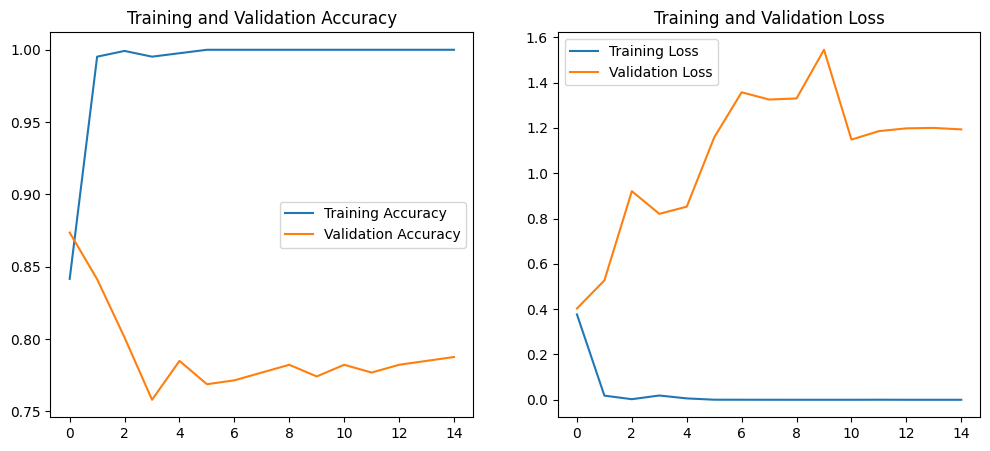

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

Inference

In [15]:
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(150,150))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    label = np.argmax(pred)

    classes = ["rock", "paper", "scissors"]

    plt.imshow(img)
    plt.axis("off")
    plt.show()

    print("Prediction:", classes[label])

(np.float64(-0.5), np.float64(2499.5), np.float64(2499.5), np.float64(-0.5))

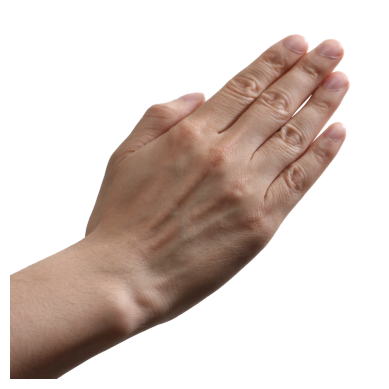

In [16]:
from PIL import Image

file_path = '/mnt/c/Users/MyBook Hype AMD/Downloads/testing_1.png'

img = Image.open(file_path)
plt.imshow(img)
plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


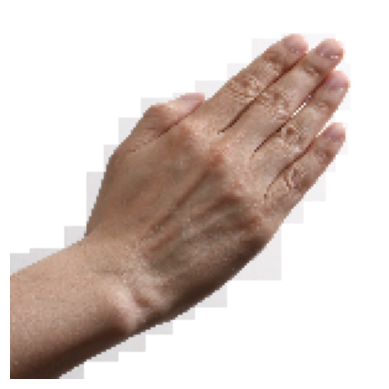

Prediction: rock


In [17]:
predict_image(file_path)